In [362]:
import os, time, shutil
from pathlib import Path
from glob import glob
import numpy as np
import spikeinterface.full as si
import matplotlib.pyplot as plt

In [2]:
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/phornauer/Git/Kilosort_2020b')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)
sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5
sorter_params['minFR'] = 0.01
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
print(sorter_params)

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/phornauer/Git/Kilosort_2020b
{'detect_threshold': 5.5, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.01, 'minfr_goodchannels': 0.01, 'nblocks': 5, 'sig': 20, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'do_correction': False, 'wave_length': 61, 'keep_good_only': False, 'n_jobs': -1, 'total_memory': None, 'chunk_size': None, 'chunk_memory': None, 'chunk_duration': '1s', 'progress_bar': True}


In [295]:
def clean_sorting(rec, save_root, stream_name):
    
    # Creates output folder, sorts and clears large temporary files
    save_path = os.path.join(save_root,stream_name)
    output_folder = Path(os.path.join(save_path, 'sorted'))
    
    if not os.path.exists(os.path.join(output_folder,'amplitudes.npy')):
        output_folder.mkdir(parents=True, exist_ok=True)
        raw_file = os.path.join(output_folder,'recording.dat')
        wh_file = os.path.join(output_folder, 'temp_wh.dat')
        
        print(f"DURATION: {rec.get_num_frames() / rec.get_sampling_frequency()} s -- "
                f"NUM. CHANNELS: {rec.get_num_channels()}")
        
        try:
            t_start_sort = time.time()
            sorting = si.run_sorter(sorter, rec, output_folder=output_folder, verbose=True,
                                    **sorter_params)
            print(f"\n\nSpike sorting elapsed time {time.time() - t_start_sort} s")
            
            #Making sure we clean up the temporary .npy files
            if os.path.exists(wh_file):
                os.remove(wh_file)
            if os.path.exists(raw_file):
                os.remove(raw_file)
        except Exception:
            if os.path.exists(wh_file):
                os.remove(wh_file)
            if os.path.exists(raw_file):
                os.remove(raw_file)
                
    return sorting

In [9]:
file_path = "/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/nobenz/230427/How_old/M05562/AxonTracking/000004/"
file_name = "data.raw.h5"
full_path = os.path.join(file_path,file_name)
stream_name = "well001"

In [64]:
assert(os.path.exists(full_path))
rec_id = 0
common_el = list(range(30000))
while True:
    rec_name = 'rec' + '%0*d' % (4, rec_id)
    try:
        rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
        rec_el = rec.get_property("contact_vector")["electrode"]
        common_el = list(set(common_el).intersection(rec_el))
        rec_id += 1
    except Exception:
        break
            

1004
269
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268
268


In [273]:
rec_list = []
for r in range(rec_id): #rec_id
    rec_name = 'rec' + '%0*d' % (4, r)
    rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)
    ch_id = rec.get_property("contact_vector")['device_channel_indices']
    rec_el = rec.get_property("contact_vector")["electrode"]
    chan_idx = [np.where(rec_el == el)[0][0] for el in common_el]
    
    rec_list.append(rec.channel_slice(rec.get_channel_ids()[chan_idx], renamed_channel_ids=list(range(len(chan_idx)))))

multirecording = si.concatenate_recordings(rec_list)

In [291]:
path_parts = file_path.split('/')
path_parts[0] = '/'
path_parts[6] = 'intermediate_data'
path_parts[8] = 'phornauer'
save_root = os.path.join(*path_parts[0:12])

In [294]:
sorting = clean_sorting(multirecording, save_root, stream_name)

DURATION: 1920.7 s -- NUM. CHANNELS: 268
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptkid7bbhu/script.sh


write_binary_recording:   0%|          | 0/1921 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptbnt08uff/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscript3ub7to9a/script.sh
RUNNING SHELL SCRIPT: /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/run_kilosort2_5.sh


                                                                              < M A T L A B (R) >

                                                                    Copyright 1984-2020 The MathWorks, Inc.

                                                                    R2020b (9.9.0.1467703) 64-bit (glnxa64)

                                                                                August 26, 2020



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   6s. Loading raw data and applying filters... 

Time  57s. Finished preprocessing 293 batches. 

D

kilosort2_5 run time 500.91s


Spike sorting elapsed time 715.6312921047211 s


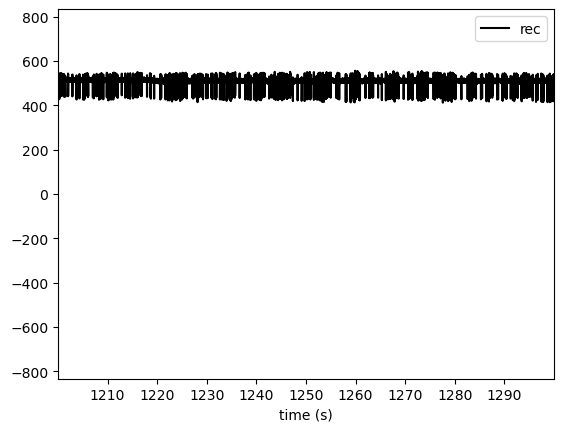

In [278]:
si.plot_timeseries(multirecording, channel_ids = [4],time_range = [1200,1300])

In [297]:
sorting = si.KiloSortSortingExtractor('/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/')

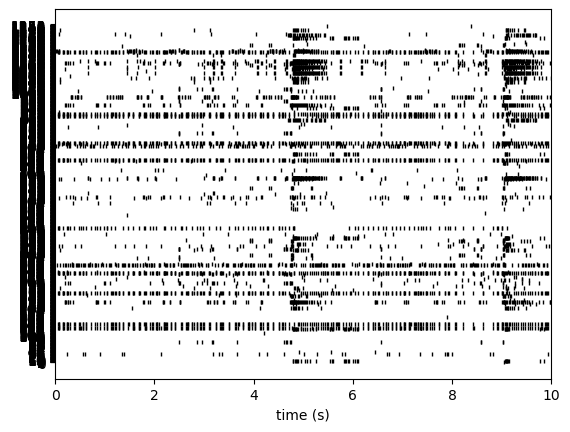

In [302]:
si.plot_rasters(sorting, time_range = [0,10])

In [314]:
19206896/10000

1920.6896

In [315]:
multirecording.get_total_duration()

1920.7

In [317]:
rec_name = 'rec0000'
rec = si.MaxwellRecordingExtractor(full_path,stream_name=stream_name,rec_name=rec_name)

In [330]:
sorting

UnitsSelectionSorting: 1010 units - 1 segments - 10.0kHz

In [335]:
frame_slice = si.FrameSliceSorting(parent_sorting = sorting, start_frame = 0, end_frame=668200)

In [337]:
wf_folder = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/230427/How_old/M05562/well001/sorted/wf/'

In [340]:
we = si.extract_waveforms(rec, frame_slice, wf_folder,
                          ms_before=1, ms_after=2., max_spikes_per_unit=500,
                          n_jobs=-1, chunk_size=30000, allow_unfiltered=True)

In [343]:
si.UnitWaveformsWidget(we, unit_ids = [0])

/home/phornauer/Git/spikeinterface/spikeinterface/widgets/unit_waveforms.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = delta_y / m * 0.7


In [403]:
wf = we.get_waveforms(6)
wf_offset = wf - np.median(wf,axis=[0,1])

In [381]:
wf_offset[1,1,3]

-18.882568

In [410]:
mean_wf = np.mean(wf_offset,axis=0)
mean_wf.shape

(30, 1004)

In [411]:
r,c = np.where(mean_wf == np.min(mean_wf))

In [412]:
sig_idx = [any(mean_wf[:,w] < -10) for w in range(1004)]

In [413]:
np.where(sig_idx)

(array([372, 641, 653, 693, 797, 801, 805, 809, 813, 989]),)

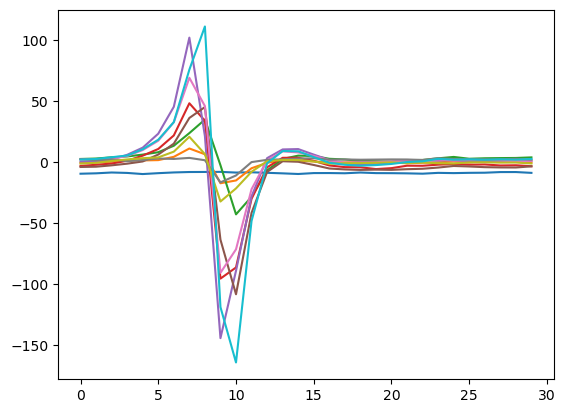

In [414]:
plt.plot(mean_wf[:,np.where(sig_idx)[0]])

In [400]:
si.UnitWaveformsWidget(we, channel_ids = np.where(sig_idx)[0], unit_ids = 6)

ValueError: 372 is not in list

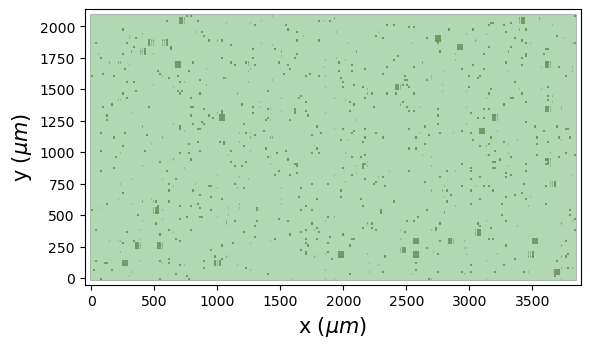

In [229]:
si.plot_probe_map(rec)